In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.layers import SpatialDropout1D
import joblib

In [3]:
# Load cleaned dataset
df = pd.read_csv("data_cleaned.csv")
df.head()

,title,text,subject,date,real
0,Donald Trump Sends Out Embarrassing New Yearâ...,Donald Trump just couldn t wish all Americans ...,News,12/31/2017,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,12/31/2017,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,12/30/2017,0
3,Trump Is So Obsessed He Even Has Obamaâ€™s Na...,"On Christmas day, Donald Trump announced that ...",News,12/29/2017,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,12/25/2017,0


In [4]:
# Define features (statements) and labels
texts = df["text"].astype(str).values  # Ensure text data is string
y = df["real"].values

# Tokenization & Sequence Padding
max_words = 10000  # Vocabulary size
max_len = 100  # Max sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Split dataset into training (80%) and testing (20%)
# X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42, stratify=y)


In [5]:
# Build Optimized LSTM-GRU Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.3)),
    Bidirectional(GRU(64, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# # Build LSTM Model
# model = Sequential([
#     Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
#     Bidirectional(LSTM(64, return_sequences=True)),
#     Dropout(0.5),
#     Bidirectional(GRU(32)),
#     Dense(32, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

# Compile Model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])

# Train Model
#history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/10


/opt/anaconda3/envs/dev/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


559/559 ━━━━━━━━━━━━━━━━━━━━ 312s 552ms/step - accuracy: 0.8530 - loss: 0.3000 - val_accuracy: 0.9898 - val_loss: 0.0330
Epoch 2/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 324s 580ms/step - accuracy: 0.9913 - loss: 0.0316 - val_accuracy: 0.9907 - val_loss: 0.0296
Epoch 3/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 335s 599ms/step - accuracy: 0.9963 - loss: 0.0167 - val_accuracy: 0.9923 - val_loss: 0.0348
Epoch 4/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 330s 590ms/step - accuracy: 0.9973 - loss: 0.0101 - val_accuracy: 0.9921 - val_loss: 0.0350
Epoch 5/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 313s 560ms/step - accuracy: 0.9975 - loss: 0.0081 - val_accuracy: 0.9918 - val_loss: 0.0359


In [6]:
# Evaluate Model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f"LSTM-GRU Model Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

280/280 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step
LSTM-GRU Model Accuracy: 0.9907
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4690
           1       0.99      0.99      0.99      4242

    accuracy                           0.99      8932
   macro avg       0.99      0.99      0.99      8932
weighted avg       0.99      0.99      0.99      8932



In [7]:
# Save Model & Tokenizer
model.save("fake_news_lstm_model.h5")
joblib.dump(tokenizer, "tokenizer.pkl")
print("LSTM-GRU model and tokenizer saved!")

LSTM-GRU model and tokenizer saved!


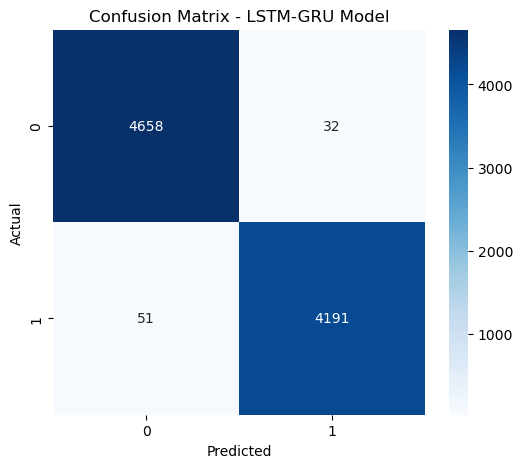

In [8]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - LSTM-GRU Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()